In [1]:
import numpy as np
from model_vanilla_shiftx import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt
import os

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
file_name = 'shiftx_aug_argminW_lr0.0002_new_aug_75ep'
out_dir_path = '/data/scratch/jahanian/mnist_dcgantf_bkup/out_old'
checkpoint_dir = os.path.join(out_dir_path,file_name,'checkpoint' )
sample_dir = os.path.join(out_dir_path,file_name,'sample' )
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

shiftx aug is disabled
loading mnist without augmenting ...
Building model_vanilla_shiftx ...
 [*] Reading checkpoints... /data/scratch/jahanian/mnist_dcgantf_bkup/out_old/shiftx_aug_argminW_lr0.0002_new_aug_75ep/checkpoint
INFO:tensorflow:Restoring parameters from /data/scratch/jahanian/mnist_dcgantf_bkup/out_old/shiftx_aug_argminW_lr0.0002_new_aug_75ep/checkpoint/model.b64-81600
 [*] Success to read model.b64-81600


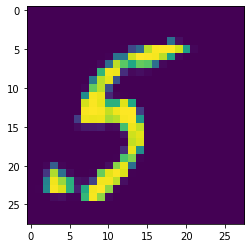

In [8]:
## Testing previously trained G
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(FLAGS.y_dim, num_samples)
y_one_hot = np.zeros((num_samples, FLAGS.y_dim))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [9]:
## steerability walk
## define the graph
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

## this will go to get_target and then to the loss
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)

z_new = z_placeholder+alpha*w
y_new = y_placeholder

## this is our transformed
transformed_output = dcgan.my_sampler(z_new, y_new)

loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

## the graph already contains DCGAN and now we want to init the steerability part in it:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [10]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    
    mask_fn = np.ones(outputs_zs.shape)
    if alpha == 0:
        return outputs_zs, mask_fn
    
    M = np.float32([[1,0,alpha],[0,1,0]])
    target_fn = np.zeros(outputs_zs.shape)
    mask_out = np.zeros(outputs_zs.shape)
    for i in range(outputs_zs.shape[0]):
        target_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(outputs_zs[i,:,:,:], M, (img_size, img_size)), axis=2)
        mask_out[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)

    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)
        
    if show_img:
        print('Target image:')
#         imshow_unscaled(target_fn)
        imshow(target_fn[0,:,:,0], im_size=128)
    if show_mask:
        print('Target mask:')
#         imshow_unscaled(mask_out)
        imshow(mask_out[0,:,:,0], im_size=128)

    return target_fn, mask_out

In [11]:
# ! mkdir -p shift_l2_git/images
# ! mkdir -p shift_l2_git/output
import os
output_dir = './out/walk_train_aug/shiftx_l2_git{}'.format(lr)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'output'), exist_ok=True)
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [12]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(output_dir, 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []
loss_vals = []

# train
train_sample_size = 20000
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples = train_sample_size
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []
    Loss_sum_iter = 0  
    alpha_val_max = 5
    
    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            alpha_val = np.random.randint(1, alpha_val_max + 1)  
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = -alpha_val

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)
            Loss_sum = Loss_sum + curr_loss
            Loss_sum_iter = Loss_sum_iter + curr_loss
            
            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))

            alpha_list.append(alpha_val)

            if (optim_iter % 2500 == 0) and (optim_iter > 0):
                saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)
            
            if (optim_iter % 100 == 0) and (optim_iter > 0):
                loss_vals.append(Loss_sum_iter/(100*batch_size))
                Loss_sum_iter = 0
                print('Loss:', loss_vals)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)

In [13]:
train(dcgan.saver)

2019-09-23 20:07:29,569 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.19838976860046387, 0, 0, 0.16066093742847443, 3
2019-09-23 20:07:29,579 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007855415344238281, 0, 10, 0.19028513133525848, -4
2019-09-23 20:07:29,588 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007951974868774414, 0, 20, 0.1217723861336708, 1
2019-09-23 20:07:29,598 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008860111236572266, 0, 30, 0.1755887269973755, -3
2019-09-23 20:07:29,610 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009890556335449219, 0, 40, 0.16653233766555786, 5
2019-09-23 20:07:29,621 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009558916091918945, 0, 50, 0.1543758362531662, -2
2019-09-23 20:07:29,632 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009754180908203125, 0, 60, 0.14659319818019867, -3
2019-09-23 20:07:29,642 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009161710739135742, 0, 70, 0.1860080510377884, -5
2019-09-23 20:07:29,652 [MainThre

2019-09-23 20:07:30,281 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007901430130004883, 0, 680, 0.14875540137290955, 3
2019-09-23 20:07:30,289 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007108926773071289, 0, 690, 0.1659453809261322, -5
2019-09-23 20:07:30,298 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008512496948242188, 0, 700, 0.10380057245492935, 1
2019-09-23 20:07:30,309 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008810997009277344, 0, 710, 0.07322796434164047, -1
2019-09-23 20:07:30,319 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008811712265014648, 0, 720, 0.11289602518081665, 2
2019-09-23 20:07:30,329 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009332418441772461, 0, 730, 0.15641354024410248, 4
2019-09-23 20:07:30,339 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008838415145874023, 0, 740, 0.09346236288547516, 1
2019-09-23 20:07:30,349 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00862431526184082, 0, 750, 0.14045637845993042, -4
2019-09-23 20:07:30,359

2019-09-23 20:07:30,964 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008862495422363281, 0, 1350, 0.06913206726312637, -1
2019-09-23 20:07:30,973 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008208990097045898, 0, 1360, 0.1496860831975937, 5
2019-09-23 20:07:30,983 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007911920547485352, 0, 1370, 0.1460556834936142, -5
2019-09-23 20:07:30,992 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008070945739746094, 0, 1380, 0.135872021317482, 3
2019-09-23 20:07:31,001 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007649898529052734, 0, 1390, 0.1603754460811615, 4
2019-09-23 20:07:31,010 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008316278457641602, 0, 1400, 0.11915506422519684, 2
2019-09-23 20:07:31,020 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008599042892456055, 0, 1410, 0.13378898799419403, -2
2019-09-23 20:07:31,030 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008508682250976562, 0, 1420, 0.14713749289512634, 5
2019-09-23 20:07:3

2019-09-23 20:07:31,651 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01061248779296875, 0, 2010, 0.1028546541929245, -2
2019-09-23 20:07:31,662 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009167909622192383, 0, 2020, 0.12030203640460968, 2
2019-09-23 20:07:31,672 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008656501770019531, 0, 2030, 0.1439693570137024, -3
2019-09-23 20:07:31,682 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008270263671875, 0, 2040, 0.13738568127155304, -5
2019-09-23 20:07:31,693 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009664773941040039, 0, 2050, 0.11617019772529602, -3
2019-09-23 20:07:31,704 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009743928909301758, 0, 2060, 0.13437753915786743, 5
2019-09-23 20:07:31,714 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00896453857421875, 0, 2070, 0.153118297457695, -5
2019-09-23 20:07:31,725 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009063005447387695, 0, 2080, 0.14986509084701538, 5
2019-09-23 20:07:31,

2019-09-23 20:07:32,334 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00890803337097168, 0, 2680, 0.10333182662725449, 2
2019-09-23 20:07:32,351 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015587568283081055, 0, 2690, 0.05365237966179848, 1
2019-09-23 20:07:32,363 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011449098587036133, 0, 2700, 0.10409367829561234, -4
2019-09-23 20:07:32,375 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00978851318359375, 0, 2710, 0.05813863128423691, 1
2019-09-23 20:07:32,385 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009201288223266602, 0, 2720, 0.14741356670856476, -5
2019-09-23 20:07:32,395 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008820533752441406, 0, 2730, 0.12266728281974792, -3
2019-09-23 20:07:32,405 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008844614028930664, 0, 2740, 0.14037545025348663, -5
2019-09-23 20:07:32,416 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009740591049194336, 0, 2750, 0.10197944194078445, 3
2019-09-23 20:

2019-09-23 20:07:33,064 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014431953430175781, 0, 3340, 0.10381978005170822, 4
2019-09-23 20:07:33,074 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008987903594970703, 0, 3350, 0.0684027150273323, -1
2019-09-23 20:07:33,084 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00882577896118164, 0, 3360, 0.15802600979804993, -5
2019-09-23 20:07:33,096 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0101776123046875, 0, 3370, 0.11162957549095154, 2
2019-09-23 20:07:33,107 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009653806686401367, 0, 3380, 0.10902959108352661, 3
2019-09-23 20:07:33,118 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010234594345092773, 0, 3390, 0.15111272037029266, 5
2019-09-23 20:07:33,129 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009461402893066406, 0, 3400, 0.06592829525470734, 1
2019-09-23 20:07:33,140 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0094451904296875, 0, 3410, 0.10966621339321136, 3
2019-09-23 20:07:33,

Loss: [0.013973436757922172, 0.012134104929864407, 0.01136790295317769, 0.011579487521201371]
2019-09-23 20:07:33,761 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009067535400390625, 0, 4010, 0.1037583202123642, 3
2019-09-23 20:07:33,771 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009032964706420898, 0, 4020, 0.09217160940170288, -2
2019-09-23 20:07:33,781 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008966207504272461, 0, 4030, 0.1438741534948349, -4
2019-09-23 20:07:33,793 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011061906814575195, 0, 4040, 0.0681244358420372, 1
2019-09-23 20:07:33,804 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009107589721679688, 0, 4050, 0.13963159918785095, -5
2019-09-23 20:07:33,814 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008970975875854492, 0, 4060, 0.0693085789680481, -1
2019-09-23 20:07:33,824 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008765935897827148, 0, 4070, 0.16222712397575378, 5
2019-09-23 20:07:33,834 [MainThread  ] [INFO 

2019-09-23 20:07:34,447 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009191036224365234, 0, 4670, 0.043143950402736664, 1
2019-09-23 20:07:34,457 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009277582168579102, 0, 4680, 0.10445404052734375, 4
2019-09-23 20:07:34,468 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009027957916259766, 0, 4690, 0.13954240083694458, -4
2019-09-23 20:07:34,479 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01021718978881836, 0, 4700, 0.09938045591115952, -3
2019-09-23 20:07:34,492 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010722875595092773, 0, 4710, 0.13364747166633606, 5
2019-09-23 20:07:34,503 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00971531867980957, 0, 4720, 0.1302177757024765, -4
2019-09-23 20:07:34,514 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009093284606933594, 0, 4730, 0.05302845686674118, 1
2019-09-23 20:07:34,524 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009308099746704102, 0, 4740, 0.07909444719552994, 2
2019-09-23 20:0

2019-09-23 20:07:35,161 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009498357772827148, 0, 5330, 0.12233345210552216, 4
2019-09-23 20:07:35,171 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008956193923950195, 0, 5340, 0.036495596170425415, -1
2019-09-23 20:07:35,182 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00925302505493164, 0, 5350, 0.08768898993730545, 2
2019-09-23 20:07:35,192 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008723258972167969, 0, 5360, 0.125559464097023, 4
2019-09-23 20:07:35,202 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009000062942504883, 0, 5370, 0.13932570815086365, 5
2019-09-23 20:07:35,212 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009126901626586914, 0, 5380, 0.11314556747674942, 3
2019-09-23 20:07:35,223 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00975489616394043, 0, 5390, 0.03984526917338371, -1
2019-09-23 20:07:35,235 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010113716125488281, 0, 5400, 0.07107596844434738, 2
2019-09-23 20:07:

2019-09-23 20:07:35,858 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008947610855102539, 0, 6000, 0.12126849591732025, 5
Loss: [0.013973436757922172, 0.012134104929864407, 0.01136790295317769, 0.011579487521201371, 0.01031963725015521, 0.00953924523666501]
2019-09-23 20:07:35,868 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008872270584106445, 0, 6010, 0.1203095018863678, -3
2019-09-23 20:07:35,879 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009613752365112305, 0, 6020, 0.1104346513748169, 4
2019-09-23 20:07:35,889 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009447813034057617, 0, 6030, 0.04409995675086975, -1
2019-09-23 20:07:35,900 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009199857711791992, 0, 6040, 0.11173667758703232, 3
2019-09-23 20:07:35,911 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010398626327514648, 0, 6050, 0.08394917845726013, -2
2019-09-23 20:07:35,922 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009086847305297852, 0, 6060, 0.10677750408649445, 3
20

2019-09-23 20:07:36,540 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009777545928955078, 0, 6660, 0.038839440792798996, -1
2019-09-23 20:07:36,550 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00914764404296875, 0, 6670, 0.06329069286584854, 2
2019-09-23 20:07:36,561 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00945138931274414, 0, 6680, 0.10895497351884842, 4
2019-09-23 20:07:36,571 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00883793830871582, 0, 6690, 0.1253354251384735, -4
2019-09-23 20:07:36,581 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009393453598022461, 0, 6700, 0.12119783461093903, 4
2019-09-23 20:07:36,592 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009185075759887695, 0, 6710, 0.09316752105951309, -3
2019-09-23 20:07:36,602 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009428739547729492, 0, 6720, 0.09939978271722794, -4
2019-09-23 20:07:36,614 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009702205657958984, 0, 6730, 0.1286294162273407, 5
2019-09-23 20:07

2019-09-23 20:07:37,230 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008839607238769531, 0, 7320, 0.06543415784835815, -2
2019-09-23 20:07:37,238 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007403373718261719, 0, 7330, 0.0765315517783165, 3
2019-09-23 20:07:37,247 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0077228546142578125, 0, 7340, 0.02889946848154068, -1
2019-09-23 20:07:37,256 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007696866989135742, 0, 7350, 0.12522509694099426, 5
2019-09-23 20:07:37,264 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007393836975097656, 0, 7360, 0.06530499458312988, -2
2019-09-23 20:07:37,272 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007002353668212891, 0, 7370, 0.11154622584581375, -4
2019-09-23 20:07:37,282 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008498907089233398, 0, 7380, 0.14238986372947693, -5
2019-09-23 20:07:37,292 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00882101058959961, 0, 7390, 0.024710090830922127, -1
2019-09-23

2019-09-23 20:07:37,926 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009451150894165039, 0, 7990, 0.09345947206020355, 4
2019-09-23 20:07:37,936 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009273290634155273, 0, 8000, 0.0262790247797966, 1
Loss: [0.013973436757922172, 0.012134104929864407, 0.01136790295317769, 0.011579487521201371, 0.01031963725015521, 0.00953924523666501, 0.008487526696175337, 0.007842146890237928]
2019-09-23 20:07:37,947 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009215593338012695, 0, 8010, 0.05589903146028519, -2
2019-09-23 20:07:37,957 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009470701217651367, 0, 8020, 0.1266954094171524, -5
2019-09-23 20:07:37,968 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009720325469970703, 0, 8030, 0.09325346350669861, -4
2019-09-23 20:07:37,979 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008966684341430664, 0, 8040, 0.1031915545463562, 4
2019-09-23 20:07:37,994 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01442122459

2019-09-23 20:07:38,652 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010158538818359375, 0, 8650, 0.08419040590524673, 3
2019-09-23 20:07:38,664 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010133981704711914, 0, 8660, 0.12207069247961044, 5
2019-09-23 20:07:38,675 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010051250457763672, 0, 8670, 0.0325431302189827, 1
2019-09-23 20:07:38,686 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00987553596496582, 0, 8680, 0.1134098470211029, 5
2019-09-23 20:07:38,697 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010118484497070312, 0, 8690, 0.05392038822174072, -2
2019-09-23 20:07:38,708 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009723663330078125, 0, 8700, 0.09576714038848877, -3
2019-09-23 20:07:38,720 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009841442108154297, 0, 8710, 0.026493201032280922, 1
2019-09-23 20:07:38,731 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009778499603271484, 0, 8720, 0.02368262968957424, 1
2019-09-23 20:07

2019-09-23 20:07:39,347 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009121417999267578, 0, 9300, 0.07824346423149109, -3
2019-09-23 20:07:39,358 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009640932083129883, 0, 9310, 0.021367300301790237, -1
2019-09-23 20:07:39,369 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009389162063598633, 0, 9320, 0.08608685433864594, -3
2019-09-23 20:07:39,379 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009215354919433594, 0, 9330, 0.05616261810064316, -2
2019-09-23 20:07:39,387 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007112026214599609, 0, 9340, 0.10483341664075851, -5
2019-09-23 20:07:39,397 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008671760559082031, 0, 9350, 0.08997134119272232, 4
2019-09-23 20:07:39,407 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009517908096313477, 0, 9360, 0.04577065631747246, -2
2019-09-23 20:07:39,418 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009408235549926758, 0, 9370, 0.02667679637670517, 1
2019-09-2

2019-09-23 20:07:40,036 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008647918701171875, 0, 9970, 0.08124765753746033, -3
2019-09-23 20:07:40,046 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008784055709838867, 0, 9980, 0.0964914858341217, 5
2019-09-23 20:07:40,057 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00913095474243164, 0, 9990, 0.07112765312194824, 3
2019-09-23 20:07:40,065 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0071926116943359375, 0, 10000, 0.06451145559549332, 3
Loss: [0.013973436757922172, 0.012134104929864407, 0.01136790295317769, 0.011579487521201371, 0.01031963725015521, 0.00953924523666501, 0.008487526696175337, 0.007842146890237928, 0.007104576293379068, 0.0066431371364742515]
2019-09-23 20:07:40,077 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01016378402709961, 0, 10010, 0.057536780834198, -2
2019-09-23 20:07:40,088 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009360551834106445, 0, 10020, 0.054872915148735046, -2
2019-09-23 20:07:40,098 [MainThrea

2019-09-23 20:07:40,721 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009840250015258789, 0, 10620, 0.06716668605804443, -3
2019-09-23 20:07:40,733 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010112524032592773, 0, 10630, 0.04739174619317055, 2
2019-09-23 20:07:40,748 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013921499252319336, 0, 10640, 0.08471794426441193, 4
2019-09-23 20:07:40,760 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01001286506652832, 0, 10650, 0.05498616024851799, 2
2019-09-23 20:07:40,771 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009561777114868164, 0, 10660, 0.09728658944368362, 5
2019-09-23 20:07:40,781 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008839130401611328, 0, 10670, 0.022478586062788963, 1
2019-09-23 20:07:40,792 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009794235229492188, 0, 10680, 0.10243730992078781, 5
2019-09-23 20:07:40,802 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009330034255981445, 0, 10690, 0.09103915095329285, 5
2019-09

2019-09-23 20:07:41,424 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008663177490234375, 0, 11260, 0.06740576773881912, 3
2019-09-23 20:07:41,434 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00882267951965332, 0, 11270, 0.07193633168935776, 4
2019-09-23 20:07:41,451 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015341997146606445, 0, 11280, 0.09206978976726532, 4
2019-09-23 20:07:41,461 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009111881256103516, 0, 11290, 0.021958431228995323, -1
2019-09-23 20:07:41,471 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009125709533691406, 0, 11300, 0.018191222101449966, 1
2019-09-23 20:07:41,482 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009346961975097656, 0, 11310, 0.08825800567865372, -3
2019-09-23 20:07:41,502 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01891613006591797, 0, 11320, 0.04923483729362488, -2
2019-09-23 20:07:41,511 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007815837860107422, 0, 11330, 0.08946269005537033, -5
2019

2019-09-23 20:07:42,096 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00884246826171875, 0, 11920, 0.09794644266366959, -4
2019-09-23 20:07:42,107 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009055376052856445, 0, 11930, 0.048179879784584045, 2
2019-09-23 20:07:42,117 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009073734283447266, 0, 11940, 0.020443396642804146, 1
2019-09-23 20:07:42,127 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008733034133911133, 0, 11950, 0.12016429007053375, -5
2019-09-23 20:07:42,137 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009084463119506836, 0, 11960, 0.01931157521903515, -1
2019-09-23 20:07:42,148 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009332656860351562, 0, 11970, 0.10384632647037506, -5
2019-09-23 20:07:42,158 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009143829345703125, 0, 11980, 0.06957735121250153, 3
2019-09-23 20:07:42,169 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008960247039794922, 0, 11990, 0.023173023015260696, -1
2

2019-09-23 20:07:42,771 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008920907974243164, 0, 12560, 0.06083288416266441, 3
2019-09-23 20:07:42,781 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008829116821289062, 0, 12570, 0.020961951464414597, 1
2019-09-23 20:07:42,791 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009104013442993164, 0, 12580, 0.05035865679383278, -2
2019-09-23 20:07:42,802 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00913095474243164, 0, 12590, 0.10361523181200027, 5
2019-09-23 20:07:42,812 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009319782257080078, 0, 12600, 0.07963693141937256, -4
2019-09-23 20:07:42,823 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009134769439697266, 0, 12610, 0.04508333280682564, 2
2019-09-23 20:07:42,834 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00964045524597168, 0, 12620, 0.01570584997534752, -1
2019-09-23 20:07:42,844 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009479999542236328, 0, 12630, 0.017623724415898323, 1
2019-

2019-09-23 20:07:43,440 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009548664093017578, 0, 13200, 0.08011617511510849, 4
2019-09-23 20:07:43,451 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009515047073364258, 0, 13210, 0.04403278976678848, -2
2019-09-23 20:07:43,462 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010114431381225586, 0, 13220, 0.03987448662519455, 2
2019-09-23 20:07:43,474 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010369300842285156, 0, 13230, 0.09816812723875046, 5
2019-09-23 20:07:43,485 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00998830795288086, 0, 13240, 0.06677952408790588, -3
2019-09-23 20:07:43,495 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009110689163208008, 0, 13250, 0.06680570542812347, -3
2019-09-23 20:07:43,506 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009425640106201172, 0, 13260, 0.10310903936624527, -5
2019-09-23 20:07:43,517 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00952768325805664, 0, 13270, 0.06444712728261948, -3
2019-

2019-09-23 20:07:44,139 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009406089782714844, 0, 13860, 0.08627966791391373, -5
2019-09-23 20:07:44,149 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009264469146728516, 0, 13870, 0.08646100014448166, 5
2019-09-23 20:07:44,159 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008871078491210938, 0, 13880, 0.05993698537349701, 3
2019-09-23 20:07:44,170 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009377241134643555, 0, 13890, 0.03985283151268959, -2
2019-09-23 20:07:44,180 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009296178817749023, 0, 13900, 0.07521971315145493, -5
2019-09-23 20:07:44,191 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009314298629760742, 0, 13910, 0.03447837755084038, -2
2019-09-23 20:07:44,201 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008640050888061523, 0, 13920, 0.058863285928964615, 2
2019-09-23 20:07:44,211 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00950002670288086, 0, 13930, 0.10634667426347733, -4
201

2019-09-23 20:07:44,817 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008934736251831055, 0, 14500, 0.11165337264537811, 5
2019-09-23 20:07:44,827 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009058713912963867, 0, 14510, 0.08354262262582779, 3
2019-09-23 20:07:44,838 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009376287460327148, 0, 14520, 0.09652728587388992, 5
2019-09-23 20:07:44,848 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008670568466186523, 0, 14530, 0.09347297251224518, -5
2019-09-23 20:07:44,857 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008543968200683594, 0, 14540, 0.03512568771839142, 2
2019-09-23 20:07:44,868 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008887767791748047, 0, 14550, 0.023306459188461304, -1
2019-09-23 20:07:44,878 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009134054183959961, 0, 14560, 0.02217794954776764, -1
2019-09-23 20:07:44,888 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009220600128173828, 0, 14570, 0.10112939774990082, 5
2019

2019-09-23 20:07:45,522 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008389711380004883, 0, 15140, 0.024463757872581482, 1
2019-09-23 20:07:45,531 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007921218872070312, 0, 15150, 0.05030590668320656, -2
2019-09-23 20:07:45,540 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008030414581298828, 0, 15160, 0.10012215375900269, 5
2019-09-23 20:07:45,549 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007680416107177734, 0, 15170, 0.041059039533138275, 2
2019-09-23 20:07:45,557 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007503986358642578, 0, 15180, 0.08526260405778885, -4
2019-09-23 20:07:45,566 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007418632507324219, 0, 15190, 0.08813288807868958, -5
2019-09-23 20:07:45,573 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0069391727447509766, 0, 15200, 0.09508635103702545, 5
2019-09-23 20:07:45,581 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0069081783294677734, 0, 15210, 0.08365169167518616, -4


2019-09-23 20:07:46,196 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008604288101196289, 0, 15800, 0.053675707429647446, -2
2019-09-23 20:07:46,206 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008901357650756836, 0, 15810, 0.08497557789087296, -5
2019-09-23 20:07:46,217 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009156465530395508, 0, 15820, 0.09611378610134125, 5
2019-09-23 20:07:46,227 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009254932403564453, 0, 15830, 0.0668904036283493, -3
2019-09-23 20:07:46,237 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008909463882446289, 0, 15840, 0.09546089917421341, 5
2019-09-23 20:07:46,248 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009450435638427734, 0, 15850, 0.02119007334113121, 1
2019-09-23 20:07:46,258 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009037017822265625, 0, 15860, 0.10478542000055313, -4
2019-09-23 20:07:46,268 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008824825286865234, 0, 15870, 0.02211056277155876, -1
201

2019-09-23 20:07:46,861 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00893259048461914, 0, 16430, 0.026163790374994278, -1
2019-09-23 20:07:46,871 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008904457092285156, 0, 16440, 0.03572223708033562, 1
2019-09-23 20:07:46,881 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00890970230102539, 0, 16450, 0.10479550808668137, 5
2019-09-23 20:07:46,892 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009530067443847656, 0, 16460, 0.01882048510015011, -1
2019-09-23 20:07:46,902 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008661746978759766, 0, 16470, 0.06626681983470917, 3
2019-09-23 20:07:46,912 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009121179580688477, 0, 16480, 0.026546761393547058, 1
2019-09-23 20:07:46,922 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009059667587280273, 0, 16490, 0.10409455001354218, 4
2019-09-23 20:07:46,933 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009230375289916992, 0, 16500, 0.040978603065013885, -2
2019

2019-09-23 20:07:47,522 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008305072784423828, 0, 17060, 0.06402308493852615, 3
2019-09-23 20:07:47,532 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00830841064453125, 0, 17070, 0.023180866613984108, -1
2019-09-23 20:07:47,540 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00723719596862793, 0, 17080, 0.10861598700284958, -5
2019-09-23 20:07:47,559 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.017142534255981445, 0, 17090, 0.06159413978457451, -2
2019-09-23 20:07:47,568 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008561134338378906, 0, 17100, 0.06396925449371338, -4
2019-09-23 20:07:47,578 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009004831314086914, 0, 17110, 0.055541738867759705, 3
2019-09-23 20:07:47,588 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008868932723999023, 0, 17120, 0.019026074558496475, 1
2019-09-23 20:07:47,602 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013512611389160156, 0, 17130, 0.0465959869325161, -2
201

2019-09-23 20:07:48,225 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008641481399536133, 0, 17720, 0.05341532826423645, -2
2019-09-23 20:07:48,235 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008754968643188477, 0, 17730, 0.02574750781059265, 1
2019-09-23 20:07:48,245 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008947610855102539, 0, 17740, 0.10380874574184418, 4
2019-09-23 20:07:48,255 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009069681167602539, 0, 17750, 0.06975527852773666, -3
2019-09-23 20:07:48,266 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009340047836303711, 0, 17760, 0.09367955476045609, -4
2019-09-23 20:07:48,276 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009026527404785156, 0, 17770, 0.09159842133522034, 3
2019-09-23 20:07:48,288 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010506868362426758, 0, 17780, 0.08373507857322693, 4
2019-09-23 20:07:48,298 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009129047393798828, 0, 17790, 0.10857371240854263, -5
2019

2019-09-23 20:07:48,895 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008608579635620117, 0, 18350, 0.07822762429714203, -3
2019-09-23 20:07:48,905 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008651971817016602, 0, 18360, 0.09068478643894196, -5
2019-09-23 20:07:48,915 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009303092956542969, 0, 18370, 0.11699271947145462, 5
2019-09-23 20:07:48,926 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009479761123657227, 0, 18380, 0.018314696848392487, 1
2019-09-23 20:07:48,936 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008362531661987305, 0, 18390, 0.020103970542550087, -1
2019-09-23 20:07:48,945 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008072614669799805, 0, 18400, 0.10290870070457458, 5
2019-09-23 20:07:48,956 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009257078170776367, 0, 18410, 0.04049917310476303, -2
2019-09-23 20:07:48,965 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008566617965698242, 0, 18420, 0.01748483255505562, 1
20

Loss: [0.013973436757922172, 0.012134104929864407, 0.01136790295317769, 0.011579487521201371, 0.01031963725015521, 0.00953924523666501, 0.008487526696175337, 0.007842146890237928, 0.007104576293379068, 0.0066431371364742515, 0.007159238895401359, 0.006431927898898721, 0.006338628587312997, 0.006371767425909639, 0.0069717924492433666, 0.00719205421116203, 0.006090543456375599, 0.006970229177735746, 0.006476353732869029]
2019-09-23 20:07:49,525 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00909876823425293, 0, 19010, 0.02130526304244995, -1
2019-09-23 20:07:49,536 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009243249893188477, 0, 19020, 0.06888158619403839, 3
2019-09-23 20:07:49,546 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009162187576293945, 0, 19030, 0.0940728634595871, -5
2019-09-23 20:07:49,556 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009029865264892578, 0, 19040, 0.018470145761966705, 1
2019-09-23 20:07:49,564 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006954431

2019-09-23 20:07:50,181 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009649515151977539, 0, 19640, 0.10053965449333191, -4
2019-09-23 20:07:50,191 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008323192596435547, 0, 19650, 0.09917265921831131, -4
2019-09-23 20:07:50,201 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008484125137329102, 0, 19660, 0.05168839171528816, -2
2019-09-23 20:07:50,211 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008653402328491211, 0, 19670, 0.05309520289301872, -2
2019-09-23 20:07:50,220 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008081674575805664, 0, 19680, 0.10705780982971191, 4
2019-09-23 20:07:50,230 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008870124816894531, 0, 19690, 0.04519472271203995, 2
2019-09-23 20:07:50,240 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00868844985961914, 0, 19700, 0.023791229352355003, -1
2019-09-23 20:07:50,250 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008963823318481445, 0, 19710, 0.08897782117128372, -5
20

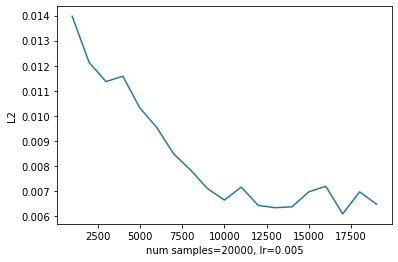

[0.013973436757922172, 0.012134104929864407, 0.01136790295317769, 0.011579487521201371, 0.01031963725015521, 0.00953924523666501, 0.008487526696175337, 0.007842146890237928, 0.007104576293379068, 0.0066431371364742515, 0.007159238895401359, 0.006431927898898721, 0.006338628587312997, 0.006371767425909639, 0.0069717924492433666, 0.00719205421116203, 0.006090543456375599, 0.006970229177735746, 0.006476353732869029]


In [14]:
import matplotlib.pyplot as plt
loss_vals_x = np.arange(FLAGS.batch_size*100, train_sample_size, FLAGS.batch_size*100)
plt.plot(loss_vals_x, loss_vals)
plt.xlabel('num samples={}, lr={}'.format(train_sample_size, lr))
plt.ylabel('L2')
plt.show()
print(loss_vals)

In [15]:
# test: show imgs 
# Need work:
# saver.restore(sess, "./out/walk_train_aug/shiftx_l2_git0.005/output/model_20000.ckpt")

[-8 -6 -5 -4 -2  0  2  4  5  6  8]


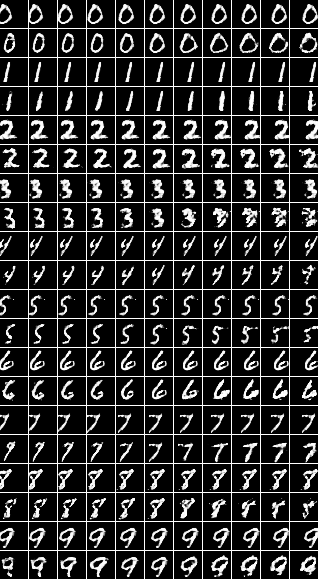

In [16]:
num_samples = 10
# a = np.array([-15, -12, -9, -6, -3,  0,  3,  6,  9, 12, 15])
a = np.array([-8, -6, -5, -4, -2,  0,  2,  4,  5, 6,  8])

zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

im_targets = []
im_transformed = []
for i in range(a.shape[0]):
    feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
    out_zs = sess.run(outputs_orig, feed_dict_out)
    target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
    im_targets.append(target_fn)
    ## get transformed:
    feed_dict = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}
    samples = sess.run(transformed_output, feed_dict=feed_dict)
    im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

ims = []
for j in range(FLAGS.y_dim):
    ims.append(np.stack([x[j, :, :, :] for x in im_targets], axis=0))
    ims.append(np.stack([x[j, :, :, :] for x in im_transformed], axis=0))

print(a)
imshow(imgrid(np.uint8(np.concatenate(ims)*255), cols=a.shape[0]))

In [17]:
loss_l2_sample = tf.reduce_sum(tf.multiply(tf.square(transformed_output-target), mask), axis=(1,2,3)) \
        / tf.reduce_sum(mask, axis=(1,2,3))

loss_l2_trained = loss

In [18]:
import logging
import sys
# import argparse
# from utils import *
# import graphs
# import constants
import time
import pdb
import os
# import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

num_samples = 10000
vocab_size = FLAGS.y_dim
batch_size = FLAGS.batch_size

z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
y_one_hot = np.zeros((len(y), FLAGS.y_dim))
y_one_hot[np.arange(len(y)), y] = 1
y_one_hot = np.tile(y_one_hot,[num_samples,1])

zs = z_sample
ys = y_one_hot
alphas = a 
alphas_no_log = a

# get alphas list
# if type(g) == graphs.ZoomTransform:
#     alp = np.linspace(1, opt.max_alpha, opt.num_alphas//2 + 1)
#     b = 1/alp
#     alphas = np.concatenate((np.delete(b[::-1], -1), alp), axis=0)
#     alphas = alphas[::-1]
# else:
#     alphas = np.linspace(-opt.max_alpha, opt.max_alpha, opt.num_alphas)
ylabel = 'L2 Error'
dist_tensor = loss_l2_sample
dist_trained_tensor = loss_l2_trained
# dist_trained_tensor = loss_l2_sample
# dist_info = compute_transform_similarity(...)
# plot_similarity(dist_info...)

# # if opt.distance == 'l2':
# #     ylabel = 'L2 Distance'
# #     dist_tensor = g.loss_l2_sample
# # elif opt.distance == 'lpips':
# #     ylabel = 'Perceptual Distance'
# #     dist_tensor = g.loss_lpips_sample
# dist_info = compute_transform_similarity(ys, zs, alphas, dist_tensor)
# plot_similarity(alphas, dist_info, ylabel, output_dir, 'category_all')
# # if opt.category:
# #     for c in opt.category:
# #         ys = [c] * num_samples
# #         ys = one_hot_if_needed(ys, vocab_size)
# #         dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                                  dist_tensor)
# #         plot_similarity(alphas, dist_info, ylabel,
# #                         output_dir, 'category_{}'.format(c))
# # else:
# #     categories = np.random.randint(0, vocab_size, size=num_samples)
# #     ys = one_hot_if_needed(categories, vocab_size)
# #     dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                              dist_tensor)
# #     plot_similarity(alphas, dist_info, ylabel, output_dir,
# #                     'category_all')

In [19]:
def scale_test_alpha_for_graph(alpha, zs_batch):
#     alpha = np.log(alpha) # only for zoom
    batch_size = zs_batch.shape[0]
    slider = alpha * np.ones((batch_size, Nsliders))
    return slider

In [20]:
alphas = alphas_no_log
dist_info = np.empty((num_samples, len(alphas) - 1))
dist_trained_info = np.empty((num_samples, len(alphas)))

for batch_start in range(0, num_samples, batch_size):
    s = slice(batch_start, min(num_samples, batch_start + batch_size))
    ys_batch = ys[s]
    zs_batch = zs[s]
    im_buffer = None # save the first set of images, for consecutive diff
    for i, a in enumerate(alphas):
        slider = scale_test_alpha_for_graph(a, zs_batch)
        input_test = {y_placeholder: ys_batch,
                      z_placeholder: zs_batch,
                      alpha: slider}
        im_transform = sess.run(transformed_output, feed_dict=input_test)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
        if im_buffer is not None:
            feed_dict = {
                mask: np.ones_like(im_transform),
                transformed_output: im_transform,
                target: im_buffer
            }
            # compute consecutive lpips diffs
            dist_info[s, i-1] = sess.run(dist_tensor, feed_dict=feed_dict)
#             print('consecutive diffs:', sess.run(dist_tensor, feed_dict=feed_dict))
        im_buffer = im_transform
    
        ## now compute the loss of train:
        ## already have im_transform, so get target and mask from G(a=0,z)
        out_zs = sess.run(outputs_orig, input_test)
        target_out, mask_out = get_target_np(out_zs, a)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
#         imshow(imgrid(np.uint8(target_out*255), cols=1))
#         imshow(imgrid(np.uint8(mask_out*255), cols=1))
        feed_dict = {
            mask: mask_out,
            transformed_output: im_transform,
            target: target_out
        }
        dist_trained_info[s, i] = sess.run(dist_trained_tensor, feed_dict=feed_dict)

alpha: -7.00, dist 0.03 +/- 0.02
alpha: -5.50, dist 0.01 +/- 0.01
alpha: -4.50, dist 0.02 +/- 0.01
alpha: -3.00, dist 0.05 +/- 0.03
alpha: -1.00, dist 0.06 +/- 0.03
alpha: 1.00, dist 0.06 +/- 0.03
alpha: 3.00, dist 0.05 +/- 0.03
alpha: 4.50, dist 0.02 +/- 0.01
alpha: 5.50, dist 0.01 +/- 0.01
alpha: 7.00, dist 0.03 +/- 0.02
2019-09-23 20:09:53,904 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-09-23 20:09:53,906 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.


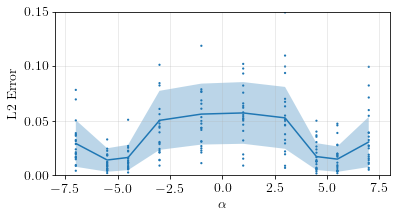

In [21]:
## plots and saves the computed similarity matrix
file_name = 'shiftx_aug_argminW_lr0.0002'
output_dir = './out/plots/shiftx'
savefile_transform_effect = file_name+'_transform_effect_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
mu = np.mean(dist_info, axis=0)
sd = np.std(dist_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.15])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile_transform_effect + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile_transform_effect + '.pdf'),
          bbox_inches="tight", pad_inches=0)

alpha: -8.00, dist 0.16 +/- 0.01
alpha: -6.00, dist 0.13 +/- 0.01
alpha: -5.00, dist 0.11 +/- 0.01
alpha: -4.00, dist 0.09 +/- 0.01
alpha: -2.00, dist 0.05 +/- 0.01
alpha: 0.00, dist 0.00 +/- 0.00
alpha: 2.00, dist 0.05 +/- 0.01
alpha: 4.00, dist 0.09 +/- 0.01
alpha: 5.00, dist 0.11 +/- 0.01
alpha: 6.00, dist 0.12 +/- 0.01
alpha: 8.00, dist 0.15 +/- 0.01


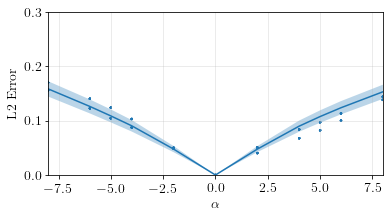

In [22]:
## plots and saves the computed similarity matrix
output_dir = './out/plots/shiftx'
savefile_loss = file_name+'_loss_trained_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
# xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
xaxis = np.mean([alphas[:], alphas[:]], axis=0)
mu = np.mean(dist_trained_info, axis=0)
sd = np.std(dist_trained_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_trained_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.3])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile_loss + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile_loss + '.pdf'),
          bbox_inches="tight", pad_inches=0)

In [24]:
np.save(os.path.join(output_dir, savefile_transform_effect+'.npy'), dist_info)
np.save(os.path.join(output_dir, savefile_loss+'.npy'), dist_trained_info)